In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [2]:

!pip install monai torchio nibabel scikit-image tqdm matplotlib

import os
import shutil
import tarfile
import random
import gc
import numpy as np
import nibabel as nib
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchio as tio
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.utils import one_hot

from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import measure

# -------------------------
# CONFIG / HYPERPARAMS

EXTRACTED_DIR = "/kaggle/working/BraTS2021/"        # folder containing patient subfolders (after extraction)
PREPROC_DIR = "/kaggle/working/preprocessed/"       # intermediate npz outputs
PREPROC_FIXED_DIR = "/kaggle/working/preprocessed_fixed/"
os.makedirs(PREPROC_DIR, exist_ok=True)
os.makedirs(PREPROC_FIXED_DIR, exist_ok=True)

TARGET_SHAPE = (96, 96, 96)    # final cubic shape used in notebook
NUM_PATIENTS = 800             # reduce for quick iteration; set to None to use all
CHANNELS = ["t1ce", "flair"]   # chosen input channels
BATCH_SIZE = 1                 # increase if GPU/memory allows
NUM_WORKERS = 2
EPOCHS = 1                     # set >1 for actual training
LR = 1e-4
WEIGHT_DECAY = 1e-5
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# -------------------------
# SAFE TAR EXTRACTION (if needed)
# -------------------------
# If you already extracted, skip this section.
# If you need to extract from a .tar file, run the safe extract. Example commented:
#
def safe_extract(tar_path, out_dir):
    def _is_secure(member, target_dir):
        abs_target = os.path.abspath(target_dir)
        abs_member = os.path.abspath(os.path.join(target_dir, member.name))
        return abs_member.startswith(abs_target)

    with tarfile.open(tar_path, "r") as tar:
        for m in tar.getmembers():
            if not _is_secure(m, out_dir):
                raise RuntimeError("Unsafe path in tar file")
        tar.extractall(path=out_dir)

safe_extract("/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar", EXTRACTED_DIR)

# -------------------------
# Build patients dictionary robustly
# -------------------------
def collect_patients(root_dir):
    patients = {}
    required_modalities = ["t1", "t1ce", "t2", "flair", "seg"]
    if not os.path.isdir(root_dir):
        raise FileNotFoundError(f"Root folder not found: {root_dir}")
    for entry in sorted(os.listdir(root_dir)):
        ppath = os.path.join(root_dir, entry)
        if not os.path.isdir(ppath):
            continue
        mod_dict = {m: None for m in required_modalities}
        for f in os.listdir(ppath):
            lf = f.lower()
            if not lf.endswith(".nii.gz"):
                continue
            fp = os.path.join(ppath, f)
            # careful ordering: t1ce must be checked before t1 match
            if "_t1ce.nii.gz" in lf:
                mod_dict["t1ce"] = fp
            elif "_t1.nii.gz" in lf and "_t1ce" not in lf:
                mod_dict["t1"] = fp
            elif "_t2.nii.gz" in lf:
                mod_dict["t2"] = fp
            elif "_flair.nii.gz" in lf:
                mod_dict["flair"] = fp
            elif "_seg.nii.gz" in lf:
                mod_dict["seg"] = fp
        if all(mod_dict[m] is not None for m in required_modalities):
            patients[entry] = mod_dict
        else:
            # skip incomplete cases but print a small message
            missing = [m for m in required_modalities if mod_dict[m] is None]
            print(f"[WARN] skipping {entry} - missing: {missing}")
    return patients

patients = collect_patients(EXTRACTED_DIR)
if len(patients) == 0:
    raise RuntimeError("No valid patient folders found in EXTRACTED_DIR; check path and extraction.")
print(f"[INFO] Found {len(patients)} patients")

# optionally limit number of patients
all_ids = list(patients.keys())
if NUM_PATIENTS is not None:
    random.shuffle(all_ids)
    selected_ids = all_ids[:NUM_PATIENTS]
else:
    selected_ids = all_ids

print(f"[INFO] Selected {len(selected_ids)} patients for preprocessing.")

# -------------------------
# Preprocessing helpers
# -------------------------
def load_nii_as_np(path):
    """Load NIfTI -> numpy float32"""
    return nib.load(path).get_fdata().astype(np.float32)

def zscore_nonzero(volume):
    mask = volume != 0
    if mask.sum() == 0:
        # nothing to normalize
        return volume
    vals = volume[mask]
    m = vals.mean()
    s = vals.std()
    if s < 1e-6:
        return volume - m
    return (volume - m) / (s + 1e-6)

def safe_get_joint_bbox(volumes):
    """
    Compute joint bbox across volumes.
    If the mask is empty (very unlikely), return a central crop bbox.
    """
    mask = np.zeros_like(volumes[0], dtype=bool)
    for v in volumes:
        mask |= (v != 0)
    if not mask.any():
        # fallback: use center region with shape TARGET_SHAPE if larger than vol dims
        vol_shape = volumes[0].shape
        minc = np.maximum(0, np.array(vol_shape)//2 - np.array(TARGET_SHAPE)//2)
        maxc = np.minimum(np.array(vol_shape)-1, minc + np.array(TARGET_SHAPE) - 1)
        return minc, maxc
    coords = np.array(np.nonzero(mask))
    minc = coords.min(axis=1)
    maxc = coords.max(axis=1)
    return minc, maxc

def crop_to_bbox(vol, minc, maxc):
    return vol[minc[0]:maxc[0]+1, minc[1]:maxc[1]+1, minc[2]:maxc[2]+1]

def resize_volume_trilinear(vol, out_shape):
    # vol: (D,H,W) or (H,W,D) depending; we use current (X,Y,Z)
    t = torch.tensor(vol, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,X,Y,Z)
    out = F.interpolate(t, size=out_shape, mode="trilinear", align_corners=False)
    return out.squeeze().numpy()

def resize_label_nearest(seg, out_shape):
    t = torch.tensor(seg, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    out = F.interpolate(t, size=out_shape, mode="nearest")
    return out.squeeze().numpy().astype(np.uint8)

def remap_brats_labels(seg):
    """
    Map original BraTS labels {0,1,2,4} to our working labels {0,1,2} where:
      0 -> background (and also keep 1->0 per earlier mapping if desired)
    We'll follow your notebook's mapping:
      original 1 -> 0 (necrotic core)
      original 2 -> 1 (edema)
      original 4 -> 2 (enhancing tumor)
    Any unexpected label values will be mapped to 0 (background).
    """
    out = np.zeros_like(seg, dtype=np.uint8)
    out[seg == 1] = 0
    out[seg == 2] = 1
    out[seg == 4] = 2
    return out

# -------------------------
# Preprocess and save .npz per patient
# -------------------------
print("[INFO] Starting preprocessing...")
for pid in tqdm(selected_ids, desc="Preprocessing"):
    try:
        p = patients[pid]
        # Load only requested channels + seg
        loaded_channels = []
        for ch in CHANNELS:
            loaded_channels.append(load_nii_as_np(p[ch]))
        seg = load_nii_as_np(p["seg"]).astype(np.uint8)

        # Joint crop across selected channels and seg to avoid cropping away seg
        minc, maxc = safe_get_joint_bbox(loaded_channels + [seg])
        # crop
        loaded_channels = [crop_to_bbox(v, minc, maxc) for v in loaded_channels]
        seg = crop_to_bbox(seg, minc, maxc)

        # Normalize each channel
        loaded_channels = [zscore_nonzero(v) for v in loaded_channels]

        # Resize channels and seg
        resized_chs = [resize_volume_trilinear(v, TARGET_SHAPE) for v in loaded_channels]
        resized_seg = resize_label_nearest(seg, TARGET_SHAPE)

        # Stack channels (C, X, Y, Z)
        image = np.stack(resized_chs, axis=0).astype(np.float32)

        # Save compressed
        out_path = os.path.join(PREPROC_DIR, f"{pid}.npz")
        np.savez_compressed(out_path, image=image.astype(np.float16), seg=resized_seg.astype(np.uint8))

    except Exception as e:
        print(f"[ERROR] Preprocessing {pid}: {e}")
        continue

print("[INFO] Preprocessing finished.")

# -------------------------
# Fix labels and ensure they are only in {0,1,2}
# -------------------------
print("[INFO] Fixing label maps and saving to:", PREPROC_FIXED_DIR)
files = sorted([f for f in os.listdir(PREPROC_DIR) if f.endswith(".npz")])
for fn in tqdm(files, desc="Fixing labels"):
    src = os.path.join(PREPROC_DIR, fn)
    dst = os.path.join(PREPROC_FIXED_DIR, fn)
    try:
        npz = np.load(src, allow_pickle=False)
        image = npz["image"].astype(np.float16)
        seg = npz["seg"].astype(np.uint8)
        # If seg contains values outside {0,1,2}, remap
        uniques = np.unique(seg)
        if not np.all(np.isin(uniques, [0,1,2])):
            seg = remap_brats_labels(seg)
        np.savez_compressed(dst, image=image, seg=seg)
    except Exception as e:
        print(f"[ERROR] fixing {fn}: {e}")

# quick verification
fixed_files = sorted([f for f in os.listdir(PREPROC_FIXED_DIR) if f.endswith(".npz")])
if len(fixed_files) == 0:
    raise RuntimeError("No fixed preprocessed files found - aborting.")
print("[INFO] Number of preprocessed-fixed files:", len(fixed_files))

# -------------------------
# Dataset class
# -------------------------
class BraTSDataset(Dataset):
    """
    Loads preprocessed .npz with:
        image: (C, X, Y, Z) float16 or float32
        seg:   (X, Y, Z) uint8
    Returns TorchIO Subject style (but as tensors) so transforms can be applied elsewhere.
    """
    def __init__(self, data_dir, mode='train'):
        self.data_dir = data_dir
        self.files = sorted([f for f in os.listdir(data_dir) if f.endswith(".npz")])
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fn = self.files[idx]
        path = os.path.join(self.data_dir, fn)
        npz = np.load(path, allow_pickle=False)
        image = npz["image"].astype(np.float32)   # (C, X, Y, Z)
        seg = npz["seg"].astype(np.uint8)        # (X, Y, Z)
        # Return raw arrays; transforms will wrap into TorchIO subject
        return {
            "id": fn.replace(".npz", ""),
            "image": image,
            "seg": seg
        }

# -------------------------
# Create dataset + split
# -------------------------
full_dataset = BraTSDataset(PREPROC_FIXED_DIR)
n_total = len(full_dataset)
train_size = int(0.7 * n_total)
val_size = int(0.15 * n_total)
test_size = n_total - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED))
print(f"[INFO] splits - train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

# -------------------------
# TorchIO transforms
# -------------------------
train_transforms = tio.Compose([
    tio.RandomFlip(axes=('LR',), p=0.5),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=5, p=0.5),
    tio.RandomElasticDeformation(num_control_points=7, max_displacement=7, p=0.3),
    tio.RandomNoise(p=0.2),
    tio.RandomBlur(p=0.2),
    tio.ZNormalization(masking_method=None),  # standard z-normalization per image
    tio.CropOrPad(TARGET_SHAPE)
])

val_transforms = tio.Compose([
    tio.ZNormalization(masking_method=None),
    tio.CropOrPad(TARGET_SHAPE)
])

test_transforms = val_transforms

# Transform wrapper for subsets (works for Subset and Dataset)
class TransformWrapper(Dataset):
    def __init__(self, base_subset, transforms, mode='train'):
        self.base = base_subset   # may be Subset
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        sample = self.base[idx]  # returns dict {"id","image","seg"}
        # Build subject dict only for available items
        subject_dict = {}
        subject_dict["image"] = tio.ScalarImage(tensor=torch.tensor(sample["image"], dtype=torch.float32))
        if sample.get("seg", None) is not None:
            seg_tensor = torch.tensor(sample["seg"], dtype=torch.int64).unsqueeze(0)  # (1,X,Y,Z)
            subject_dict["seg"] = tio.LabelMap(tensor=seg_tensor)
        subject = tio.Subject(**subject_dict)
        if self.transforms is not None:
            subject = self.transforms(subject)
        # return tensors
        out = {"id": sample["id"], "image": subject["image"].data}  # (C,X,Y,Z)
        if "seg" in subject:
            out["seg"] = subject["seg"].data  # (1,X,Y,Z)
        else:
            out["seg"] = None
        return out

train_dataset = TransformWrapper(train_ds, train_transforms, mode='train')
val_dataset = TransformWrapper(val_ds, val_transforms, mode='val')
test_dataset = TransformWrapper(test_ds, test_transforms, mode='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Quick sanity print
sample = next(iter(train_loader))
print("[SANITY] image shape:", sample["image"].shape, "seg shape:", sample["seg"].shape if sample["seg"] is not None else None)

# -------------------------
# Model, loss, optimizer
# -------------------------
model = UNet(
    spatial_dims=3,
    in_channels=len(CHANNELS),
    out_channels=3,   # classes: 0,1,2
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceCELoss(
    to_onehot_y=True,
    softmax=True,
    squared_pred=True,
    include_background=False
)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

dice_metric = DiceMetric(include_background=False, reduction="mean")

hausdorff_metric = HausdorffDistanceMetric(
    include_background=False,
    percentile=95,
    reduction="mean"
)

 # Hausdorff95 per-class

print("[INFO] Model & loss ready. Device:", device)

# -------------------------
# Training loop with validation + checkpoint
# -------------------------
scaler = GradScaler()
best_val_dice = -1.0
checkpoint_path = "/kaggle/working/best_model.pth"

# Safety: ensure deterministic-ish
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Train")
    for batch in pbar:
        imgs = batch["image"].to(device)            # (B,C,X,Y,Z)
        segs = batch["seg"].to(device).long()      # (B,1,X,Y,Z)

        # guard: ensure seg values in 0..2
        if torch.any(segs < 0) or torch.any(segs > 2):
            raise ValueError("Labels outside expected range {0,1,2}")

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            outputs = model(imgs)    # (B,3,X,Y,Z)
            loss = loss_function(outputs, segs)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader)
    print(f"[TRAIN] Epoch {epoch+1} avg loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    dice_metric.reset()
    hausdorff_metric.reset()
    with torch.no_grad():
        pbarv = tqdm(val_loader, desc=f"Epoch {epoch+1} Val")
        for batch in pbarv:
            imgs = batch["image"].to(device)
            segs = batch["seg"].to(device).long()  # (B,1,X,Y,Z)
            with autocast():
                out = model(imgs)   # (B,3,...)
            # preds
            preds = torch.argmax(out, dim=1, keepdim=True)  # (B,1,...)
            # one-hot them for metrics
            segs_oh = one_hot(segs, num_classes=3)
            preds_oh = one_hot(preds, num_classes=3)
            dice_metric(y_pred=preds_oh, y=segs_oh)
            hausdorff_metric(y_pred=preds_oh, y=segs_oh)

    try:
        val_dice = dice_metric.aggregate().item()
    except Exception:
        val_dice = float(dice_metric.aggregate())  # fallback

    # hausdorff_metric returns a tensor per class aggregated? get_component_names?
    # monai.HausdorffDistance aggregate returns tensor shaped (num_classes) when reduction='mean' etc.
    hd_vals = hausdorff_metric.aggregate()
    # Convert hd_vals to numpy list: shape (num_classes,)
    if isinstance(hd_vals, torch.Tensor):
        hd_vals = hd_vals.cpu().numpy().tolist()
    else:
        # in some versions it returns scalar or list
        pass

    print(f"[VAL] Epoch {epoch+1} Dice (mean over classes): {val_dice:.4f}")
    print(f"[VAL] Epoch {epoch+1} Hausdorff95 per-class (classes 0..2): {hd_vals}")


    # Save best checkpoint
    if val_dice > best_val_dice:
        best_val_dice = val_dice

        checkpoint = {
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_dice": val_dice,
        }
    
        torch.save(checkpoint, checkpoint_path)
        print(f"[CHECKPOINT] Saved best model (val_dice={val_dice:.4f}) to {checkpoint_path}")


    # reset metrics states
    dice_metric.reset()
    hausdorff_metric.reset()

print("[TRAINING COMPLETE] best_val_dice:", best_val_dice)

# -------------------------
# Test-time prediction + Dice & Hausdorff on test set
# -------------------------
# Load best model
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    print(f"[INFO] Loaded checkpoint from {checkpoint_path} (epoch {ckpt.get('epoch', '?')})")

model.eval()
dice_metric.reset()
hausdorff_metric.reset()
test_dice_scores = []
test_hd_scores = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        imgs = batch["image"].to(device)
        segs = batch["seg"].to(device).long()

        out = model(imgs)
        preds = torch.argmax(out, dim=1, keepdim=True)
        segs_oh = one_hot(segs, num_classes=3)
        preds_oh = one_hot(preds, num_classes=3)
        dice_metric(y_pred=preds_oh, y=segs_oh)
        hausdorff_metric(y_pred=preds_oh, y=segs_oh)

dice_test = dice_metric.aggregate().item()
hd_test = hausdorff_metric.aggregate()
if isinstance(hd_test, torch.Tensor):
    hd_test = hd_test.cpu().numpy().tolist()

print(f"[TEST] Mean Dice: {dice_test:.4f}")
print(f"[TEST] Hausdorff95 per-class: {hd_test}")

# -------------------------
# Visualization helpers
# -------------------------
def visualize_slice(image_tensor, seg_tensor=None, pred_tensor=None, slice_idx=None, channel_idx=0):
    """
    image_tensor: (C, X, Y, Z) torch tensor or numpy
    seg_tensor: (1, X, Y, Z) or numpy
    pred_tensor: (1, X, Y, Z) or logits/tensor -> will convert via argmax if needed
    """
    if isinstance(image_tensor, torch.Tensor):
        img = image_tensor.cpu().numpy()
    else:
        img = np.asarray(image_tensor)
    if seg_tensor is not None:
        seg = seg_tensor.cpu().numpy().squeeze(0)
    else:
        seg = None
    if pred_tensor is not None:
        # if logits, ensure it's class indices
        if pred_tensor.ndim == 5 and pred_tensor.shape[1] > 1:
            p = torch.argmax(pred_tensor, dim=1, keepdim=True).cpu().numpy().squeeze(0)
        else:
            p = pred_tensor.cpu().numpy().squeeze(0)
    else:
        p = None

    # choose middle slice if not provided
    if slice_idx is None:
        slice_idx = img.shape[-1] // 2

    channel_slice = img[channel_idx, :, :, slice_idx]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(channel_slice, cmap='gray')
    plt.title("Input channel")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    if seg is not None:
        plt.imshow(channel_slice, cmap='gray')
        plt.imshow(seg[:, :, slice_idx], cmap='jet', alpha=0.5)
        plt.title("Ground truth")
        plt.axis('off')
    else:
        plt.title("No GT")
        plt.axis('off')

    plt.subplot(1, 3, 3)
    if p is not None:
        plt.imshow(channel_slice, cmap='gray')
        plt.imshow(p[:, :, slice_idx], cmap='jet', alpha=0.5)
        plt.title("Prediction")
        plt.axis('off')
    else:
        plt.title("No pred")
        plt.axis('off')

    plt.show()

def render_3d_surface(seg_volume, class_id=2, spacing=(1.0,1.0,1.0)):
    """
    Render a 3D triangular mesh (vertices, faces) for a given class using marching cubes.
    seg_volume: numpy array (X,Y,Z)
    Returns vertices, faces for potential plotting or saving.
    """
    mask = (seg_volume == class_id).astype(np.uint8)
    if mask.sum() == 0:
        print(f"[WARN] No voxels for class {class_id} in provided volume.")
        return None, None
    # marching_cubes expects volume shape (Z,Y,X) or (X,Y,Z) - skimage works with (X,Y,Z)
    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5, spacing=spacing)
    return verts, faces

# # Visualize a few test samples
# print("[INFO] Visualizing a few test samples...")
# cnt = 0
# with torch.no_grad():
#     for batch in test_loader:
#         imgs = batch["image"].to(device)
#         segs = batch["seg"].to(device).long()
#         out = model(imgs)
#         preds = torch.argmax(out, dim=1, keepdim=True)
#         visualize_slice(imgs[0], segs[0], preds.unsqueeze(0))
#         # 3D render for predicted class 2 (enhancing tumor), if present
#         pred_np = preds[0,0].cpu().numpy()
#         verts, faces = render_3d_surface(pred_np, class_id=2)
#         if verts is not None:
#             print("[INFO] Surface mesh vertices:", verts.shape, "faces:", faces.shape)
#         cnt += 1
#         if cnt >= 3:
#             break

# print("[ALL DONE] You can now: increase EPOCHS, change channels to include T1/T2, tune augmentations, or replace the UNet with Swin-UNet.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 39.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-11-14 11:21:21.982311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763119282.190789      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763119282.253125      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[INFO] Found 1251 patients
[INFO] Selected 800 patients for preprocessing.
[INFO] Starting preprocessing...


Preprocessing: 100%|██████████| 800/800 [08:39<00:00,  1.54it/s]


[INFO] Preprocessing finished.
[INFO] Fixing label maps and saving to: /kaggle/working/preprocessed_fixed/


Fixing labels: 100%|██████████| 800/800 [01:44<00:00,  7.65it/s]

[INFO] Number of preprocessed-fixed files: 800
[INFO] splits - train: 560, val: 120, test: 120



/tmp/ipykernel_48/3803592439.py:391: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[SANITY] image shape: torch.Size([1, 2, 96, 96, 96]) seg shape: torch.Size([1, 1, 96, 96, 96])
[INFO] Model & loss ready. Device: cuda


Epoch 1/1 Train:   0%|          | 0/560 [00:00<?, ?it/s]/tmp/ipykernel_48/3803592439.py:411: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/1 Train: 100%|██████████| 560/560 [06:40<00:00,  1.40it/s, loss=0.6363]


[TRAIN] Epoch 1 avg loss: 1.1537


Epoch 1 Val:   0%|          | 0/120 [00:00<?, ?it/s]/tmp/ipykernel_48/3803592439.py:434: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)
Epoch 1 Val: 100%|██████████| 120/120 [00:17<00:00,  6.75it/s]


[VAL] Epoch 1 Dice (mean over classes): 0.5169
[VAL] Epoch 1 Hausdorff95 per-class (classes 0..2): [14.897937774658203]
[CHECKPOINT] Saved best model (val_dice=0.5169) to /kaggle/working/best_model.pth
[TRAINING COMPLETE] best_val_dice: 0.5168549418449402
[INFO] Loaded checkpoint from /kaggle/working/best_model.pth (epoch 1)


Testing:  63%|██████▎   | 76/120 [00:11<00:07,  6.24it/s]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:327: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
Testing: 100%|██████████| 120/120 [00:17<00:00,  6.71it/s]

[TEST] Mean Dice: 0.5193
[TEST] Hausdorff95 per-class: [15.406213760375977]


In [3]:
def visualize_case(image, label, pred, channel=0, slice_idx=None):
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert tensors -> numpy
    image = image.cpu().numpy() if isinstance(image, torch.Tensor) else image
    label = label.cpu().numpy() if isinstance(label, torch.Tensor) else label
    pred  = pred.cpu().numpy()  if isinstance(pred, torch.Tensor) else pred

    # Remove channel dims if needed
    if label.ndim == 4:  # (1,X,Y,Z)
        label = label.squeeze(0)
    if pred.ndim == 4:   # (1,X,Y,Z)
        pred = pred.squeeze(0)

    if slice_idx is None:
        slice_idx = image.shape[-1] // 2

    img_slice = image[channel, :, :, slice_idx]
    gt_slice  = label[:, :, slice_idx]
    pr_slice  = pred[:, :, slice_idx]

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    axs[0].imshow(img_slice, cmap='gray')
    axs[0].set_title("Input MRI")
    axs[0].axis("off")

    axs[1].imshow(img_slice, cmap='gray')
    axs[1].imshow(gt_slice, cmap='jet', alpha=0.4)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(img_slice, cmap='gray')
    axs[2].imshow(pr_slice, cmap='jet', alpha=0.4)
    axs[2].set_title("Prediction")
    axs[2].axis("off")

    plt.show()


In [4]:
import torch
from tqdm import tqdm
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.utils import one_hot
from torch.cuda.amp import autocast, GradScaler

# ============================================================
# CONFIG
# ============================================================
EPOCHS = 7           
best_val_dice = -1
checkpoint_path = "/kaggle/working/best_model_v2.pth"

dice_metric = DiceMetric(include_background=False, reduction="mean")
hausdorff_metric = HausdorffDistanceMetric(
    include_background=False,
    percentile=95,
    reduction="mean"
)

scaler = GradScaler()   # <-- OK on Kaggle

# ============================================================
# TRAINING LOOP
# ============================================================
for epoch in range(EPOCHS):

    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Training {epoch+1}/{EPOCHS}")

    for batch in pbar:
        images = batch["image"].to(device)
        labels = batch["seg"].to(device).long()

        optimizer.zero_grad(set_to_none=True)

        # <-- FIXED: Kaggle-safe autocast with no args
        with autocast():
            outputs = model(images)
            loss = loss_function(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    print(f"[EPOCH {epoch+1}] Train Loss = {train_loss / len(train_loader):.4f}")

    # ============================================================
    # VALIDATION
    # ============================================================
    model.eval()
    dice_metric.reset()
    hausdorff_metric.reset()

    with torch.no_grad():
        vbar = tqdm(val_loader, desc="Validating")

        for batch in vbar:
            images = batch["image"].to(device)
            labels = batch["seg"].to(device).long()

            with autocast():   # <-- FIXED here too
                outputs = model(images)

            preds = torch.argmax(outputs, dim=1, keepdim=True)

            preds_oh = one_hot(preds, num_classes=3)
            labels_oh = one_hot(labels, num_classes=3)

            dice_metric(y_pred=preds_oh, y=labels_oh)
            hausdorff_metric(y_pred=preds_oh, y=labels_oh)

    val_dice = dice_metric.aggregate().item()
    val_hd = hausdorff_metric.aggregate()

    if isinstance(val_hd, torch.Tensor):
        val_hd = val_hd.cpu().numpy().tolist()

    print(f"[EPOCH {epoch+1}] Val Dice = {val_dice:.4f}")
    print(f"[EPOCH {epoch+1}] Val Hausdorff95 per-class = {val_hd}")

    # ============================================================
    # SAVE BEST MODEL
    # ============================================================
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_dice": val_dice
        }, checkpoint_path)

        print(f"[CHECKPOINT] Saved best model (dice={val_dice:.4f})")

print("Training finished.")


/tmp/ipykernel_48/672637714.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # <-- OK on Kaggle
Training 1/7:   0%|          | 0/560 [00:00<?, ?it/s]/tmp/ipykernel_48/672637714.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training 1/7: 100%|██████████| 560/560 [06:02<00:00,  1.55it/s, loss=0.265]


[EPOCH 1] Train Loss = 0.5349


Validating:   0%|          | 0/120 [00:00<?, ?it/s]/tmp/ipykernel_48/672637714.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():   # <-- FIXED here too
Validating: 100%|██████████| 120/120 [00:17<00:00,  7.01it/s]


[EPOCH 1] Val Dice = 0.6074
[EPOCH 1] Val Hausdorff95 per-class = [14.580647468566895]
[CHECKPOINT] Saved best model (dice=0.6074)


Training 2/7: 100%|██████████| 560/560 [05:57<00:00,  1.57it/s, loss=0.273]


[EPOCH 2] Train Loss = 0.4275


Validating: 100%|██████████| 120/120 [00:15<00:00,  7.68it/s]


[EPOCH 2] Val Dice = 0.6521
[EPOCH 2] Val Hausdorff95 per-class = [10.303281784057617]
[CHECKPOINT] Saved best model (dice=0.6521)


Training 3/7: 100%|██████████| 560/560 [05:42<00:00,  1.64it/s, loss=0.305]


[EPOCH 3] Train Loss = 0.3908


Validating: 100%|██████████| 120/120 [00:15<00:00,  7.66it/s]


[EPOCH 3] Val Dice = 0.6574
[EPOCH 3] Val Hausdorff95 per-class = [10.582989692687988]
[CHECKPOINT] Saved best model (dice=0.6574)


Training 4/7: 100%|██████████| 560/560 [05:18<00:00,  1.76it/s, loss=0.536]


[EPOCH 4] Train Loss = 0.3648


Validating: 100%|██████████| 120/120 [00:16<00:00,  7.16it/s]


[EPOCH 4] Val Dice = 0.6763
[EPOCH 4] Val Hausdorff95 per-class = [11.05087661743164]
[CHECKPOINT] Saved best model (dice=0.6763)


Training 5/7: 100%|██████████| 560/560 [06:26<00:00,  1.45it/s, loss=0.205] 


[EPOCH 5] Train Loss = 0.3462


Validating: 100%|██████████| 120/120 [00:15<00:00,  7.96it/s]


[EPOCH 5] Val Dice = 0.6861
[EPOCH 5] Val Hausdorff95 per-class = [8.675176620483398]
[CHECKPOINT] Saved best model (dice=0.6861)


Training 6/7: 100%|██████████| 560/560 [06:14<00:00,  1.49it/s, loss=0.374]


[EPOCH 6] Train Loss = 0.3241


Validating: 100%|██████████| 120/120 [00:17<00:00,  7.06it/s]


[EPOCH 6] Val Dice = 0.6560
[EPOCH 6] Val Hausdorff95 per-class = [13.136499404907227]


Training 7/7: 100%|██████████| 560/560 [06:04<00:00,  1.53it/s, loss=0.182] 


[EPOCH 7] Train Loss = 0.3108


Validating:  72%|███████▏  | 86/120 [00:11<00:04,  7.55it/s]/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:332: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
Validating: 100%|██████████| 120/120 [00:15<00:00,  7.71it/s]


[EPOCH 7] Val Dice = 0.7003
[EPOCH 7] Val Hausdorff95 per-class = [8.610223770141602]
[CHECKPOINT] Saved best model (dice=0.7003)
Training finished.


In [5]:
import torch
import numpy as np
from tqdm import tqdm
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.utils import one_hot

dice_metric = DiceMetric(include_background=False, reduction="mean_batch")
hd95_metric = HausdorffDistanceMetric(
    include_background=False,
    percentile=95,
    reduction="mean_batch"
)

def compute_brats_regions(seg):
    WT = (seg == 0) | (seg == 1) | (seg == 2)
    TC = (seg == 0) | (seg == 2)
    ET = (seg == 2)
    return WT, TC, ET

WT_dices = []
TC_dices = []
ET_dices = []

print("\n[INFO] Starting evaluation on test set...")
model.eval()
dice_metric.reset()
hd95_metric.reset()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        images = batch["image"].to(device)
        labels = batch["seg"].to(device).long()

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1, keepdim=True)

        preds_oh = one_hot(preds, num_classes=3)
        labels_oh = one_hot(labels, num_classes=3)

        dice_metric(y_pred=preds_oh, y=labels_oh)
        hd95_metric(y_pred=preds_oh, y=labels_oh)

        # ---- Region Dice ----
        for i in range(images.shape[0]):
            gt_np = labels[i, 0].cpu().numpy()
            pr_np = preds[i, 0].cpu().numpy()

            gt_WT, gt_TC, gt_ET = compute_brats_regions(gt_np)
            pr_WT, pr_TC, pr_ET = compute_brats_regions(pr_np)

            def dice(a, b):
                inter = np.logical_and(a, b).sum()
                denom = a.sum() + b.sum() + 1e-6
                return 2 * inter / denom

            WT_dices.append(dice(gt_WT, pr_WT))
            TC_dices.append(dice(gt_TC, pr_TC))
            ET_dices.append(dice(gt_ET, pr_ET))


# ============================================================
# SAFE EXTRACTION OF METRICS
# ============================================================
final_dice = dice_metric.aggregate().cpu().numpy()   # may have length 1,2,3
final_hd95 = hd95_metric.aggregate().cpu().numpy()

def safe(idx, arr):
    return float(arr[idx]) if idx < len(arr) else None

dice_c0 = safe(0, final_dice)
dice_c1 = safe(1, final_dice)
dice_c2 = safe(2, final_dice)

hd_c0 = safe(0, final_hd95)
hd_c1 = safe(1, final_hd95)
hd_c2 = safe(2, final_hd95)

WT_mean = float(np.mean(WT_dices))
TC_mean = float(np.mean(TC_dices))
ET_mean = float(np.mean(ET_dices))


# ============================================================
# FINAL REPORT
# ============================================================
print("\n=================== FINAL EVALUATION REPORT ===================")

print("\nPer-Class Dice:")
print("  Class 0 (NCR/NET):", dice_c0)
print("  Class 1 (ED):     ", dice_c1)
print("  Class 2 (ET):     ", dice_c2)

print("\nPer-Class Hausdorff95:")
print("  Class 0:", hd_c0)
print("  Class 1:", hd_c1)
print("  Class 2:", hd_c2)

print("\nBraTS Region Dice:")
print("  Whole Tumor (WT):", WT_mean)
print("  Tumor Core (TC): ", TC_mean)
print("  Enhancing Tumor (ET):", ET_mean)

print("\nOverall Mean Dice:", np.mean([v for v in [dice_c0, dice_c1, dice_c2] if v is not None]))

print("\n===============================================================\n")



[INFO] Starting evaluation on test set...


Evaluating: 100%|██████████| 120/120 [00:17<00:00,  7.05it/s]


=================== FINAL EVALUATION REPORT ===================

Per-Class Dice:
  Class 0 (NCR/NET): 0.7351396083831787
  Class 1 (ED):      0.6823002696037292
  Class 2 (ET):      None

Per-Class Hausdorff95:
  Class 0: 8.585854530334473
  Class 1: 8.54870319366455
  Class 2: None

BraTS Region Dice:
  Whole Tumor (WT): 0.999999999999435
  Tumor Core (TC):  0.9954814572765595
  Enhancing Tumor (ET): 0.6823002025015579

Overall Mean Dice: 0.708719938993454





========== SAMPLE 1 ==========


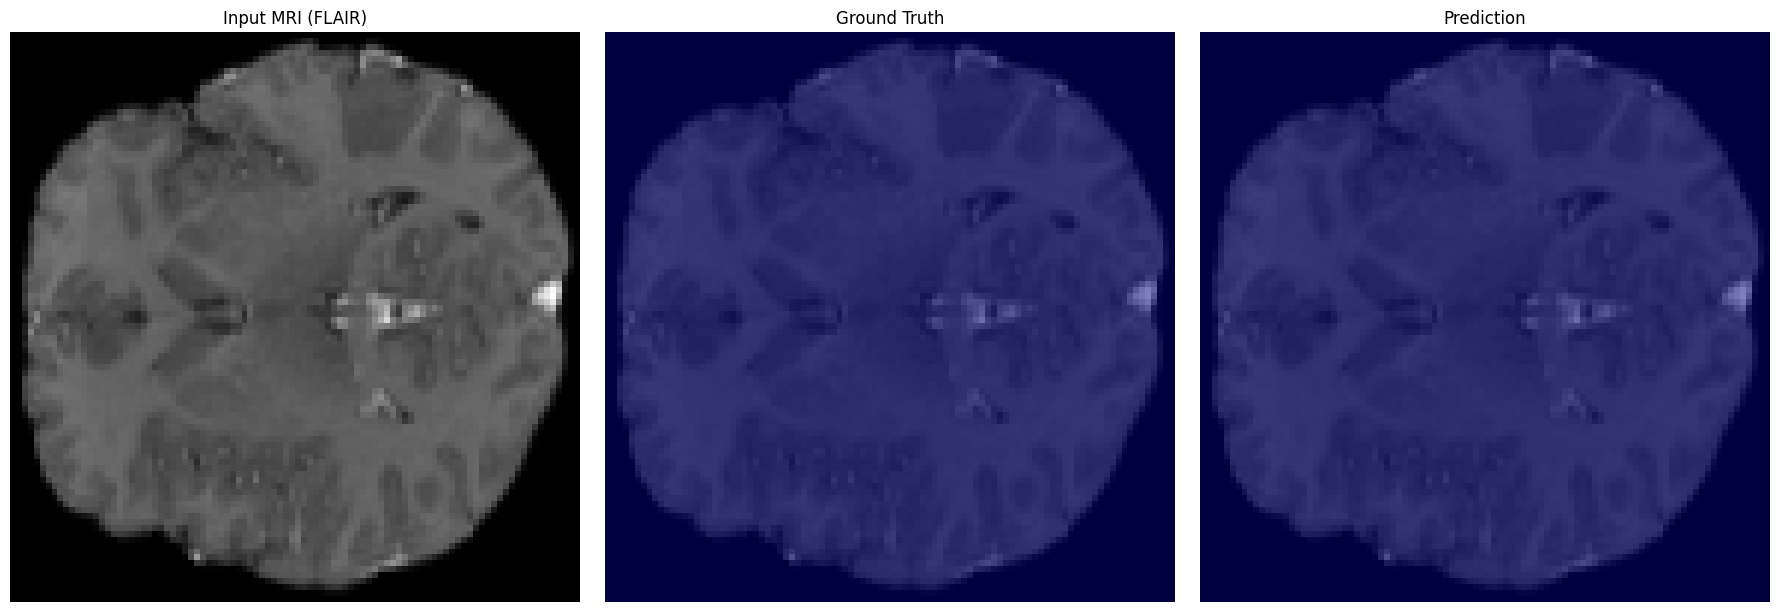

[3D] Whole Tumor (WT)
[INFO] Skipping 3D render for Whole Tumor (WT): mask is uniform.
[3D] Tumor Core (TC)


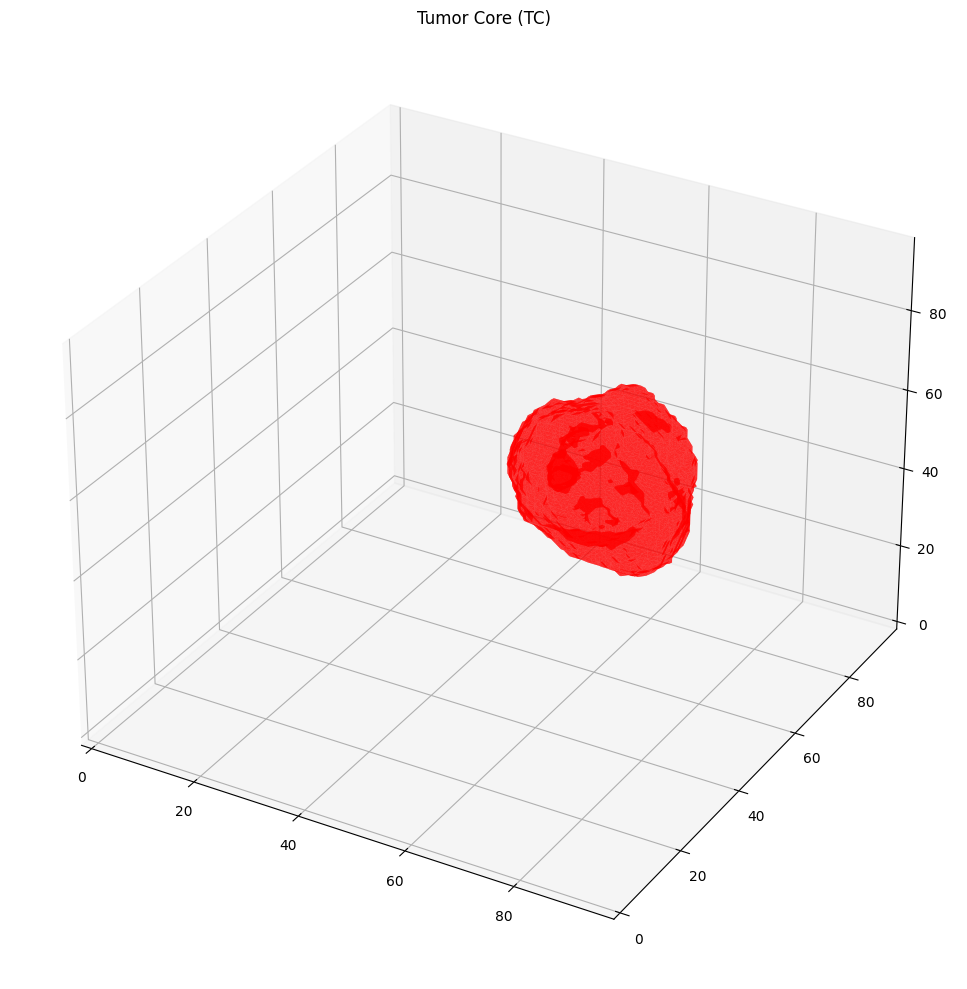

[3D] Enhancing Tumor (ET)


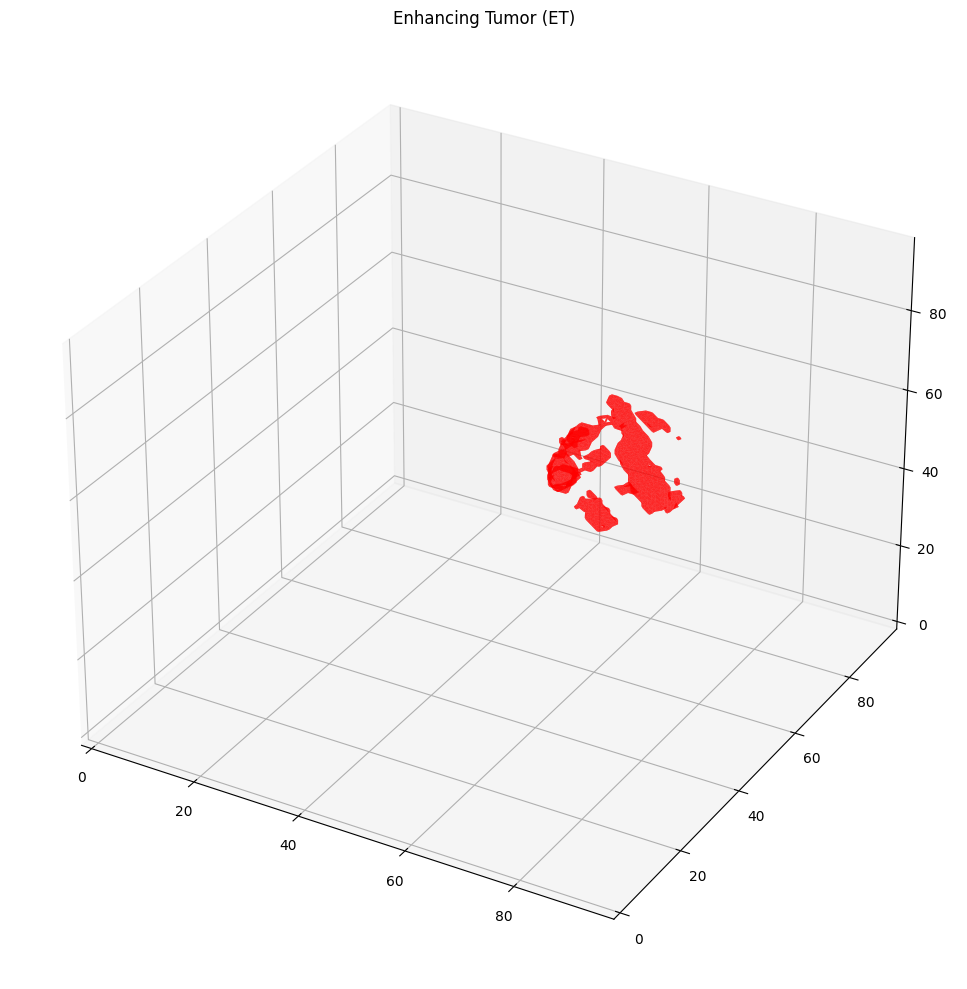


========== SAMPLE 2 ==========


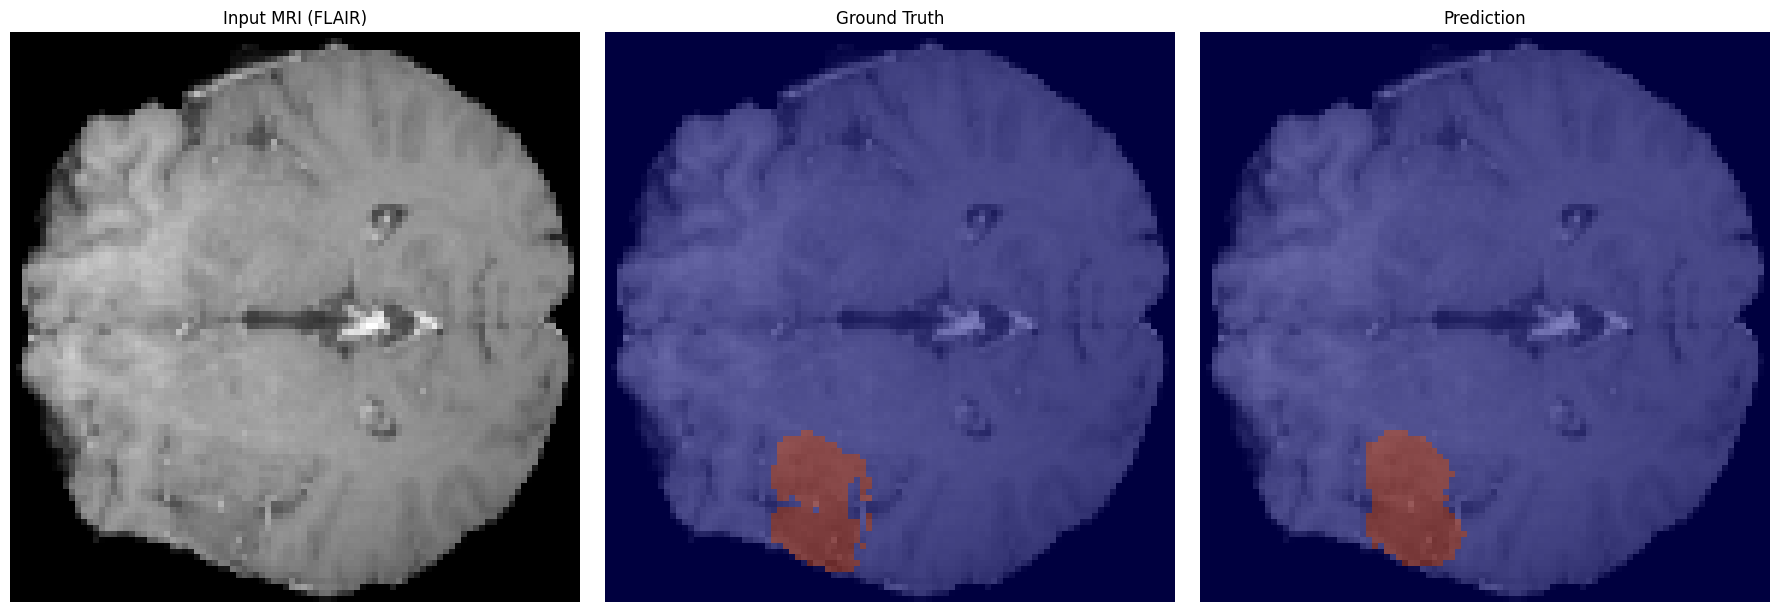

[3D] Whole Tumor (WT)
[INFO] Skipping 3D render for Whole Tumor (WT): mask is uniform.
[3D] Tumor Core (TC)


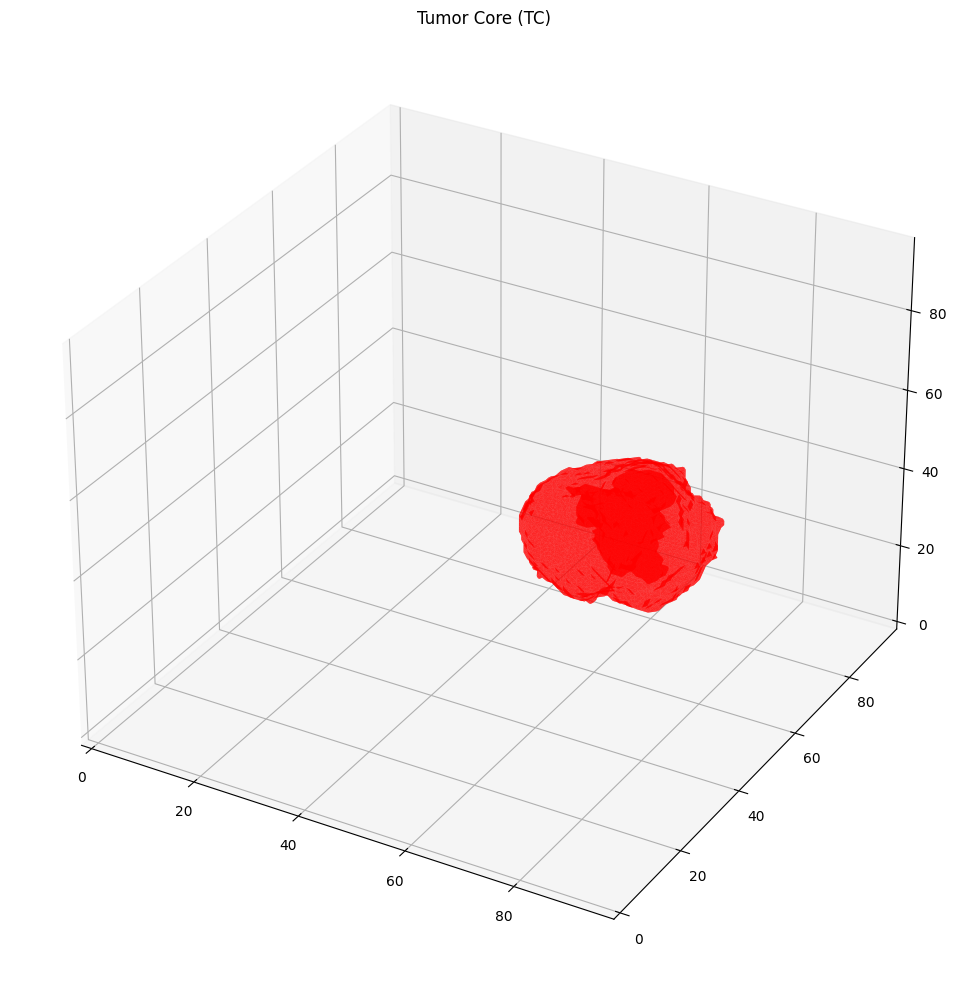

[3D] Enhancing Tumor (ET)


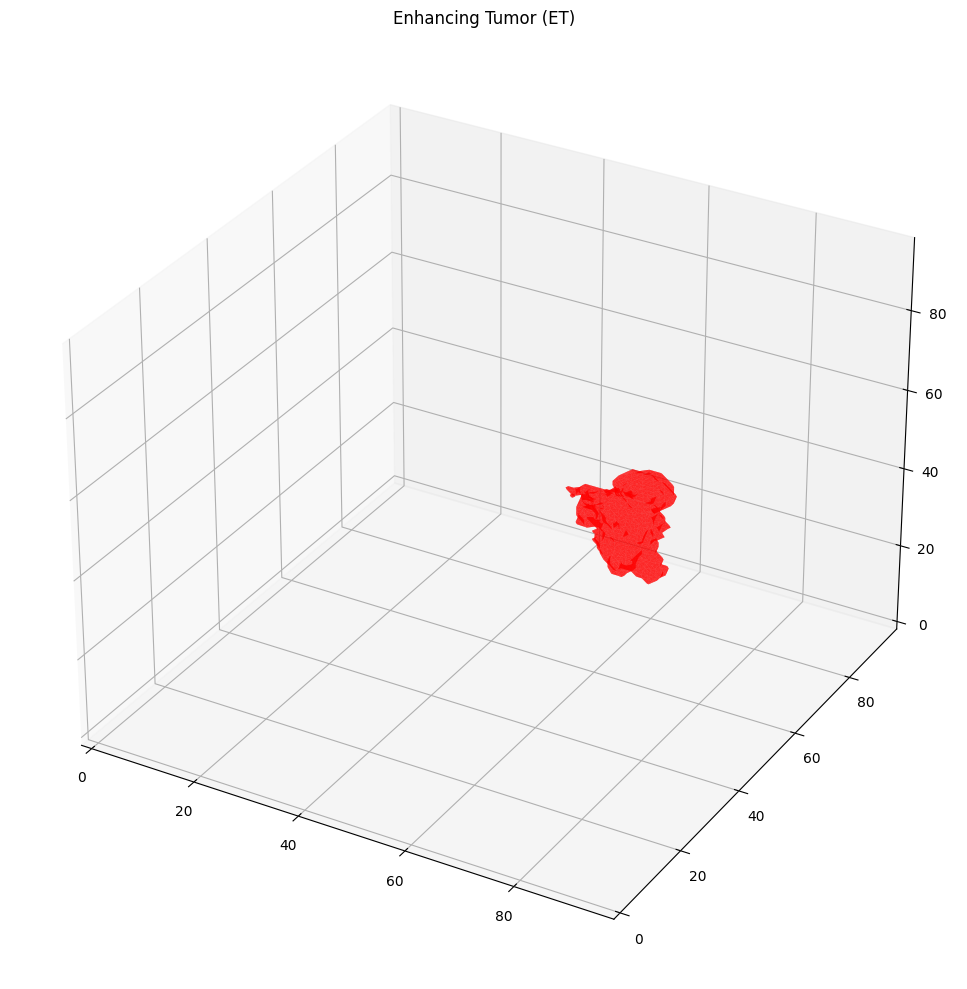


========== SAMPLE 3 ==========


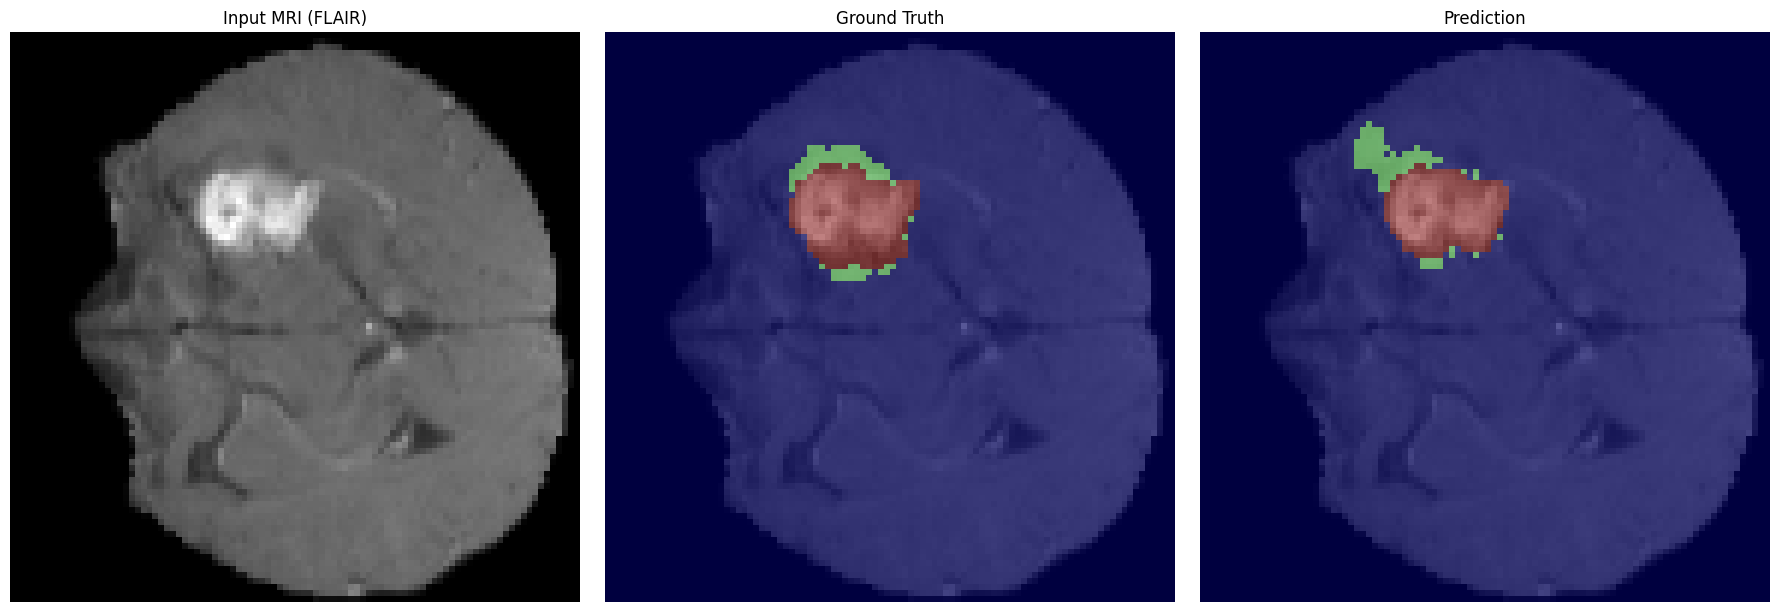

[3D] Whole Tumor (WT)
[INFO] Skipping 3D render for Whole Tumor (WT): mask is uniform.
[3D] Tumor Core (TC)


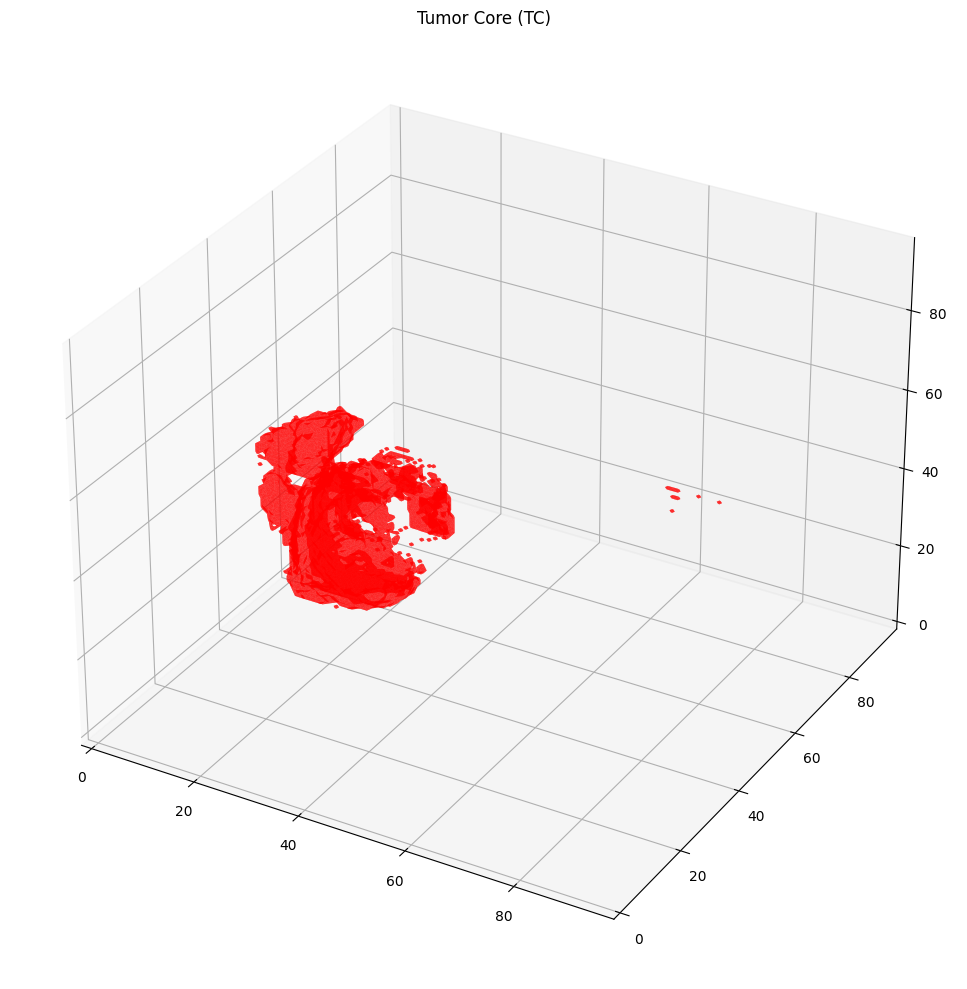

[3D] Enhancing Tumor (ET)


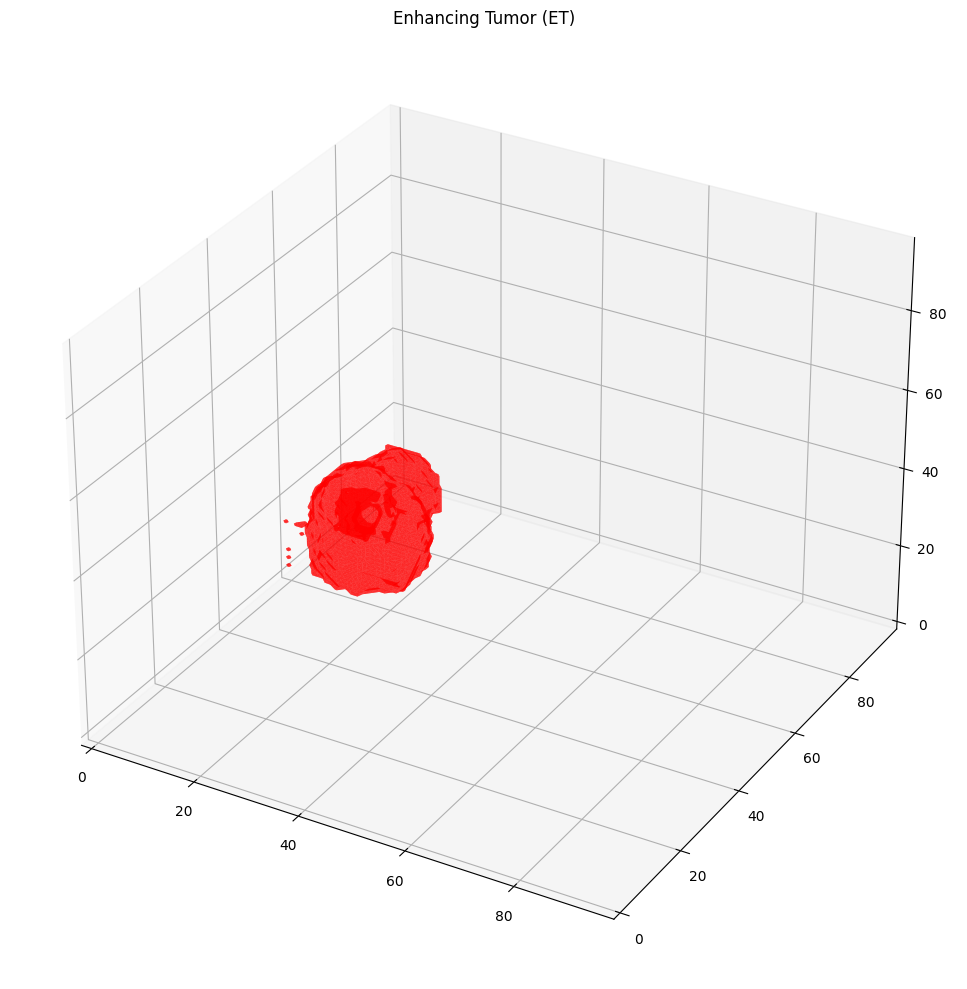

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --------------------------------------------
# SLICE VISUALIZATION (2D OVERLAY)
# --------------------------------------------
def visualize_slice(image, gt, pred, slice_idx=None, channel=0):
    image = image.cpu().numpy()
    gt = gt.cpu().numpy()
    pred = pred.cpu().numpy()

    if slice_idx is None:
        slice_idx = image.shape[-1] // 2

    img_slice  = image[channel, :, :, slice_idx]
    gt_slice   = gt[:, :, slice_idx]
    pred_slice = pred[:, :, slice_idx]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(img_slice, cmap='gray')
    axs[0].set_title("Input MRI (FLAIR)")
    axs[0].axis("off")

    axs[1].imshow(img_slice, cmap='gray')
    axs[1].imshow(gt_slice, cmap='jet', alpha=0.5)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(img_slice, cmap='gray')
    axs[2].imshow(pred_slice, cmap='jet', alpha=0.5)
    axs[2].set_title("Prediction")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


# --------------------------------------------
# SAFE 3D RENDERING FUNCTION
# --------------------------------------------
def render_3d(mask, title="3D Rendering"):
    """
    mask: boolean numpy mask or (H,W,D) array
    """
    mask_np = np.asarray(mask, dtype=np.uint8)

    # If no tumor voxels → skip
    if mask_np.sum() < 10:   # very small tumor → unreliable surface
        print(f"[INFO] Skipping 3D render for {title}: no tumor voxels.")
        return

    # marching_cubes needs both 0 and 1 present
    if mask_np.min() == mask_np.max():
        print(f"[INFO] Skipping 3D render for {title}: mask is uniform.")
        return

    verts, faces, _, _ = measure.marching_cubes(mask_np, level=0.5)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.6)
    mesh.set_facecolor("red")
    ax.add_collection3d(mesh)

    ax.set_xlim(0, mask_np.shape[0])
    ax.set_ylim(0, mask_np.shape[1])
    ax.set_zlim(0, mask_np.shape[2])
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


# --------------------------------------------
# RUN VISUALIZATION ON TEST SAMPLES
# --------------------------------------------
model.eval()
count = 0

for batch in test_loader:
    imgs = batch["image"].to(device)
    gt = batch["seg"].to(device).squeeze(1)

    with torch.no_grad():
        logits = model(imgs)
        pred = torch.argmax(logits, dim=1)

    print(f"\n========== SAMPLE {count+1} ==========")

    # 2D visualization
    visualize_slice(imgs[0], gt[0], pred[0])

    pred_mask = pred[0].cpu()

    # --------------------
    # REGION MASKS
    # --------------------
    # Whole Tumor = WT = labels 0,1,2
    wt_mask = (pred_mask == 0) | (pred_mask == 1) | (pred_mask == 2)

    # Tumor Core = TC = labels 0,2
    tc_mask = (pred_mask == 0) | (pred_mask == 2)

    # Enhancing Tumor = ET = label 2
    et_mask = (pred_mask == 2)

    # --------------------
    # 3D visualizations
    # --------------------
    print("[3D] Whole Tumor (WT)")
    render_3d(wt_mask, "Whole Tumor (WT)")

    print("[3D] Tumor Core (TC)")
    render_3d(tc_mask, "Tumor Core (TC)")

    print("[3D] Enhancing Tumor (ET)")
    render_3d(et_mask, "Enhancing Tumor (ET)")

    count += 1
    if count >= 3:   # visualize first 3 test samples
        break


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------------------------------------------------
# Create output folder
# ---------------------------------------------------
save_root = "/kaggle/working/visualizations"
os.makedirs(save_root, exist_ok=True)


# ---------------------------------------------------
# SAVEABLE SLICE VISUALIZATION
# ---------------------------------------------------
def save_slice(image, gt, pred, save_path, slice_idx=None, channel=0):
    image = image.cpu().numpy()
    gt = gt.cpu().numpy()
    pred = pred.cpu().numpy()

    if slice_idx is None:
        slice_idx = image.shape[-1] // 2

    img_slice  = image[channel, :, :, slice_idx]
    gt_slice   = gt[:, :, slice_idx]
    pred_slice = pred[:, :, slice_idx]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(img_slice, cmap='gray')
    axs[0].set_title("Input MRI (FLAIR)")
    axs[0].axis("off")

    axs[1].imshow(img_slice, cmap='gray')
    axs[1].imshow(gt_slice, cmap='jet', alpha=0.5)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(img_slice, cmap='gray')
    axs[2].imshow(pred_slice, cmap='jet', alpha=0.5)
    axs[2].set_title("Prediction")
    axs[2].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


# ---------------------------------------------------
# SAFE 3D RENDERING THAT SAVES TO FILE
# ---------------------------------------------------
def save_3d(mask, save_path, title="3D Rendering"):
    mask_np = np.asarray(mask, dtype=np.uint8)

    if mask_np.sum() < 10:
        print(f"[INFO] Skipping 3D save ({title}): mask empty.")
        return

    if mask_np.min() == mask_np.max():
        print(f"[INFO] Skipping 3D save ({title}): mask uniform.")
        return

    verts, faces, _, _ = measure.marching_cubes(mask_np, level=0.5)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.6)
    mesh.set_facecolor("red")
    ax.add_collection3d(mesh)

    ax.set_xlim(0, mask_np.shape[0])
    ax.set_ylim(0, mask_np.shape[1])
    ax.set_zlim(0, mask_np.shape[2])
    ax.set_title(title)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


# ---------------------------------------------------
# LOOP THROUGH TEST SAMPLES AND SAVE EVERYTHING
# ---------------------------------------------------
model.eval()
case_idx = 0

for batch in test_loader:
    imgs = batch["image"].to(device)
    gt   = batch["seg"].to(device).squeeze(1)

    with torch.no_grad():
        logits = model(imgs)
        pred = torch.argmax(logits, dim=1)

    pred_mask = pred[0].cpu()

    # Create folder for this test sample
    case_dir = os.path.join(save_root, f"case_{case_idx:03d}")
    os.makedirs(case_dir, exist_ok=True)

    print(f"[INFO] Saving visualizations to {case_dir}")

    # -------------------------------
    # Save 2D slice
    # -------------------------------
    save_slice(
        imgs[0], 
        gt[0], 
        pred[0],
        save_path=os.path.join(case_dir, "slice_visualization.png")
    )

    # -------------------------------
    # Region masks
    # -------------------------------
    wt_mask = (pred_mask == 0) | (pred_mask == 1) | (pred_mask == 2)
    tc_mask = (pred_mask == 0) | (pred_mask == 2)
    et_mask = (pred_mask == 2)

    # -------------------------------
    # Save 3D renders
    # -------------------------------
    save_3d(wt_mask, os.path.join(case_dir, "3D_WT.png"), "Whole Tumor (WT)")
    save_3d(tc_mask, os.path.join(case_dir, "3D_TC.png"), "Tumor Core (TC)")
    save_3d(et_mask, os.path.join(case_dir, "3D_ET.png"), "Enhancing Tumor (ET)")

    case_idx += 1

    if case_idx >= 10:   # save first 10 test samples
        break

print(f"\n[COMPLETE] All visualizations saved under: {save_root}")


[INFO] Saving visualizations to /kaggle/working/visualizations/case_000
[INFO] Skipping 3D save (Whole Tumor (WT)): mask uniform.
[INFO] Saving visualizations to /kaggle/working/visualizations/case_001
[INFO] Skipping 3D save (Whole Tumor (WT)): mask uniform.
[INFO] Saving visualizations to /kaggle/working/visualizations/case_002
[INFO] Skipping 3D save (Whole Tumor (WT)): mask uniform.
[INFO] Saving visualizations to /kaggle/working/visualizations/case_003
[INFO] Skipping 3D save (Whole Tumor (WT)): mask uniform.
[INFO] Saving visualizations to /kaggle/working/visualizations/case_004
[INFO] Skipping 3D save (Whole Tumor (WT)): mask uniform.
[INFO] Saving visualizations to /kaggle/working/visualizations/case_005
[INFO] Skipping 3D save (Whole Tumor (WT)): mask uniform.
[INFO] Saving visualizations to /kaggle/working/visualizations/case_006
[INFO] Skipping 3D save (Whole Tumor (WT)): mask uniform.
[INFO] Saving visualizations to /kaggle/working/visualizations/case_007
[INFO] Skipping 3D